#### Ensure Gensim is installed:

pip install gensim

pip install --upgrade gensim

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from gensim import corpora, similarities, matutils
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

### Vector representation of words. Analogies.

In [ ]:
corpus = api.load('text8')
print(type(corpus))

In [ ]:
num_docs=0
num_words = 0
for doc in corpus:
    num_words += len(doc)
    num_docs += 1
    
print(f'Number of documents in the corpus: {num_docs}')
assert num_docs != 0
print(f'Number of words in a document: {int(num_words/num_docs)}')

In [ ]:
model = Word2Vec(corpus)

In [ ]:
model.wv.most_similar('philosophy')

In [ ]:
model.wv.most_similar(positive=['longest', 'high'], negative=['long'])[0]

In [ ]:
model.wv.most_similar(positive=['japan', 'german'], negative=['japanese'])[0]

In [ ]:
model.wv.most_similar(positive=['trumpet', 'fight'], negative=['music'])[0]

In [ ]:
model.wv.doesnt_match('idiots kant understand hegel'.split())

## Documents to Bag of Words. Cosine similarity between documents

### Bag of Words

A <b>Bag of Words model </b> represents each distinct word with the number of its occurrences in the document.

It assumes that <b> the position of the words does not matter </b>.

An example application of it is <b> Spam Detection </b>, where purely the existence of specific words could imply the type of email /"stock", "Viagra" & "buy" are usually more likely to be found in a Spam mail/.

See below a visualization of the model.

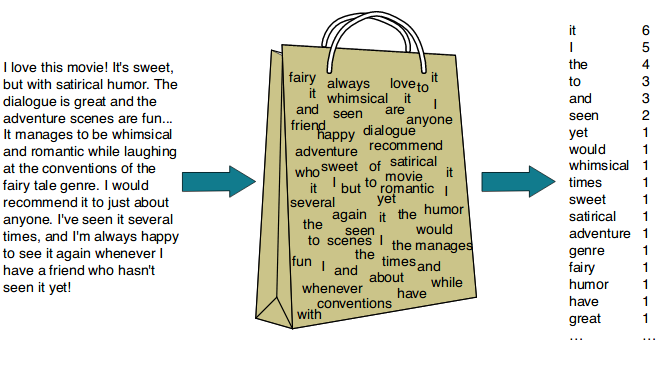

In [ ]:
investopedia = """
    Married but separated spouses
    Starting in tax year 2021, married but separated spouses will be able to choose 
    to be treated as not married for the purposes of claiming the EITC. 
    The spouse who claims the credit cannot file jointly with the other spouse and 
    they must have a qualifying child living with them for more than half the year.
""".split()

investopedia2 = """
    Single people and couples with children
    They can claim the EITC even even if their children do not have SSNs. 
    This will result in the smaller credit available to workers who do not have qualifying children.
    Taxpayers planning to make this claim should complete Schedule EIC and attach it to Form 1040 or 1040-SR 
    if they have at least one qualifying child without a valid SSN.
""".split()

shakespeare = """
    I rather tell thee what is to be fear'd
    Than what I fear; for always I am Caesar.
    Come on my right hand, for this ear is deaf,
    And tell me truly what thou think'st of him.
""".split()

In [ ]:
documents = [investopedia, investopedia2, shakespeare]
dictionary = corpora.Dictionary(documents)

In [ ]:
investopedia_vec = dictionary.doc2bow(investopedia)
investopedia2_vec = dictionary.doc2bow(investopedia2)
shakespeare_vec = dictionary.doc2bow(shakespeare)

In [ ]:
investopedia_vec[:5]

In [ ]:
# Let us look at the top 5 most frequent words in the document
top_investopedia = sorted(investopedia_vec, key=lambda k: k[1], reverse=True)[:5]
top_investopedia

In [ ]:
# Let's see which words are in top_investopedia
top_investopedia_indices = [word[0] for word in top_investopedia]
print(top_investopedia_indices)

# Iterate over the entries in the dictionary and find the occurrences
for word, encoding in dictionary.token2id.items():
    if encoding in top_investopedia_indices:
        print(word, encoding)

### Cosine similarity

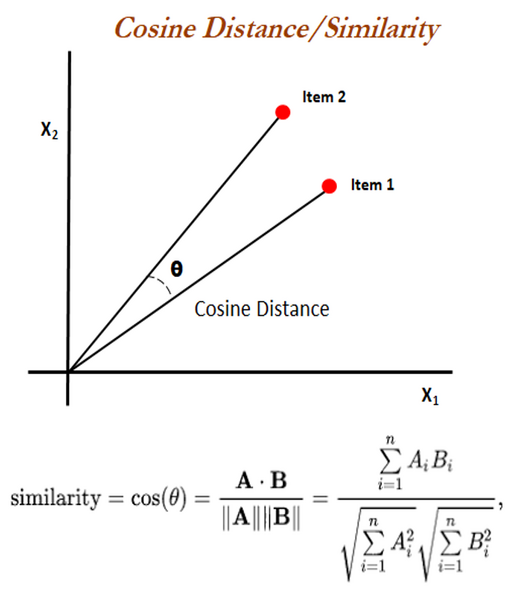

In [ ]:
# Comparing two completely different documents results in low similarity
sim = matutils.cossim(investopedia_vec, shakespeare_vec)
print(f'Similarity between two BoW vectors is {100*np.round(sim,2)}%%')

In [ ]:
# However, comparing two excerpts from the same document could also result in low similarity 
# * if the dictionary from the corpus is small or
# * if an author suddenly changes the style & topic of his text.

sim = matutils.cossim(investopedia_vec, investopedia2_vec)
print(f'Similarity between two BoW vectors is {100*np.round(sim,2)}%%')

## Classifiers: sentiment analysis

In [ ]:
import pandas as pd
df = pd.read_csv("trip_hotel_review.csv")
df.head()

To make it a bit easier for our classifier, let's split the ratings in two categories:
* Positive: 1 (if rating > 2.5)
* Negative: 0 (if rating <= 2.5)

In [ ]:
df['Rating'] = np.where(df['Rating'] > 2.5, 1, 0)
df.head()

Now preprocess the reviews to get rid of useless characters and split each sentence in its components

In [ ]:
from gensim.utils import simple_preprocess
df['tokenized_text'] = [simple_preprocess(review, deacc=True) for review in df['Review']] 
df.head()

Now produce the stemmed version of each sentence out of the preprocessed version.
Stemming consists in porting words into their "base" form. 

For example: faster -> fast, doing -> do

In [ ]:
from gensim.parsing.porter import PorterStemmer

porter_stemmer = PorterStemmer()

df['stemmed_text'] = [[porter_stemmer.stem(word) for word in words] for words in df['tokenized_text']]
df.head()

Let's create a model that gives a vector representation of each word

In [ ]:
vector_size = 100  # Size of the vector representation of words
window = 3  # Size of the window
min_count = 1  # Model words only if their frequency is >= to min_count
workers = 3  # Number of threads to be used
sg = 1  # 1: Skip-gram. 0: CBOW

stemmed_text = pd.Series(df['stemmed_text']).values

w2v_model = Word2Vec(stemmed_text, min_count=min_count, vector_size=vector_size, workers=workers, window=window, sg=sg)

In [ ]:
def sentence_to_vector(sentence, model):
    """Transforms a sentence into a vector by computing the average vector for each word in the sentence"""
    
    representation = np.zeros(shape=(vector_size,))  # The resulting array will have shape=(vector_size,)

    for word in sentence:
        representation += model.wv[word]  # Add the vector representation of word

    return representation/len(sentence)

Now store the data to build the model

In [ ]:
# Get the ratings array
ratings_vec = df["Rating"].to_numpy()

In [ ]:
# Get an array where each entry is the vectorised version of each sentence in df["stemmed_text"] by applying
# sentence_to_vector()
review_vec = np.array(df["stemmed_text"].apply(lambda sentence: sentence_to_vector(sentence, w2v_model)).values)

In [ ]:
# Create train-test split of the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(review_vec, ratings_vec, test_size=0.3, random_state=42)

Feed the data to the classifier

In [ ]:
# Get KNN classifier with 11 neighbours and fit it to the data
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=11)

classifier.fit(list(X_train), Y_train)

In [ ]:
# Calculate the score
classifier.score(list(X_test), Y_test)